In [1]:
# Import the required packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [2]:
# Import the dataset
df = pd.read_csv('./car data.csv')

In [3]:
# Pre-process the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
df['Car_Name'].nunique()

98

In [5]:
df.drop('Car_Name', axis=1, inplace=True)

In [6]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)

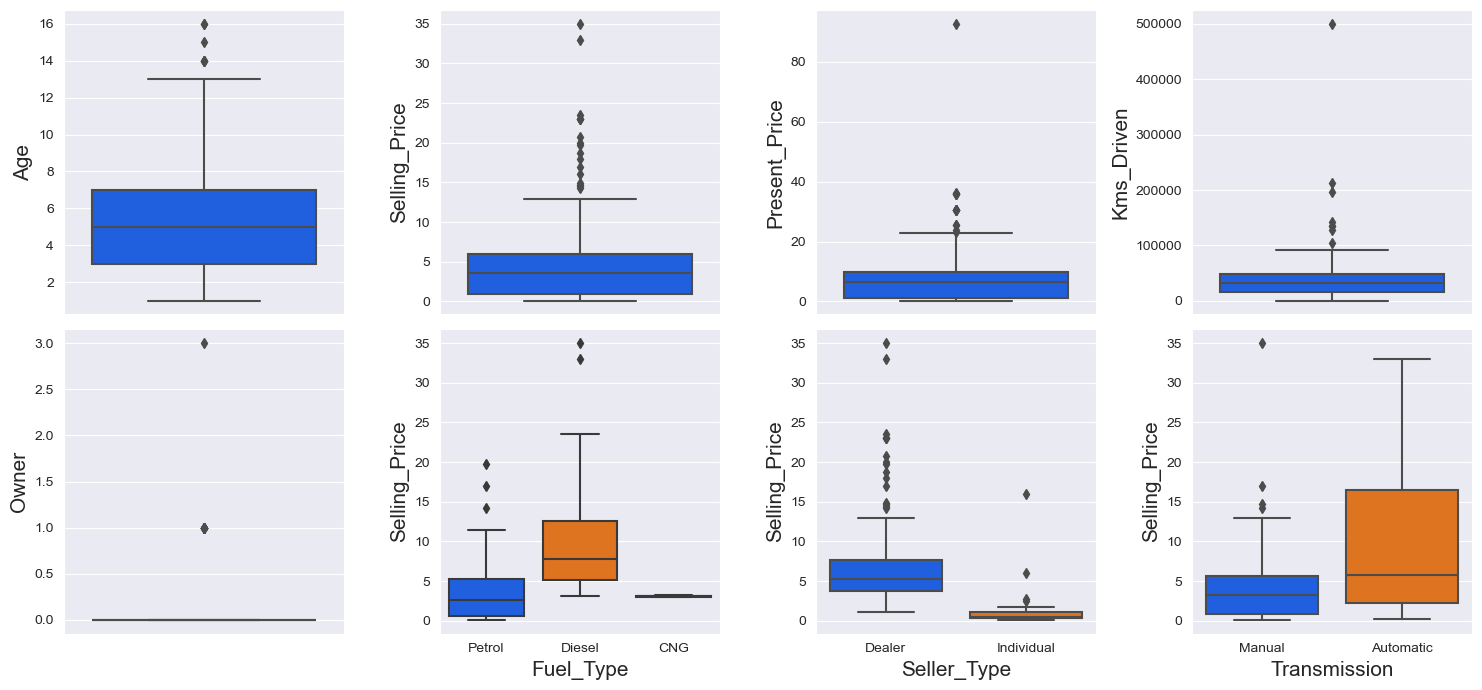

In [8]:
# How to find outliers
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,  df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

In [9]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


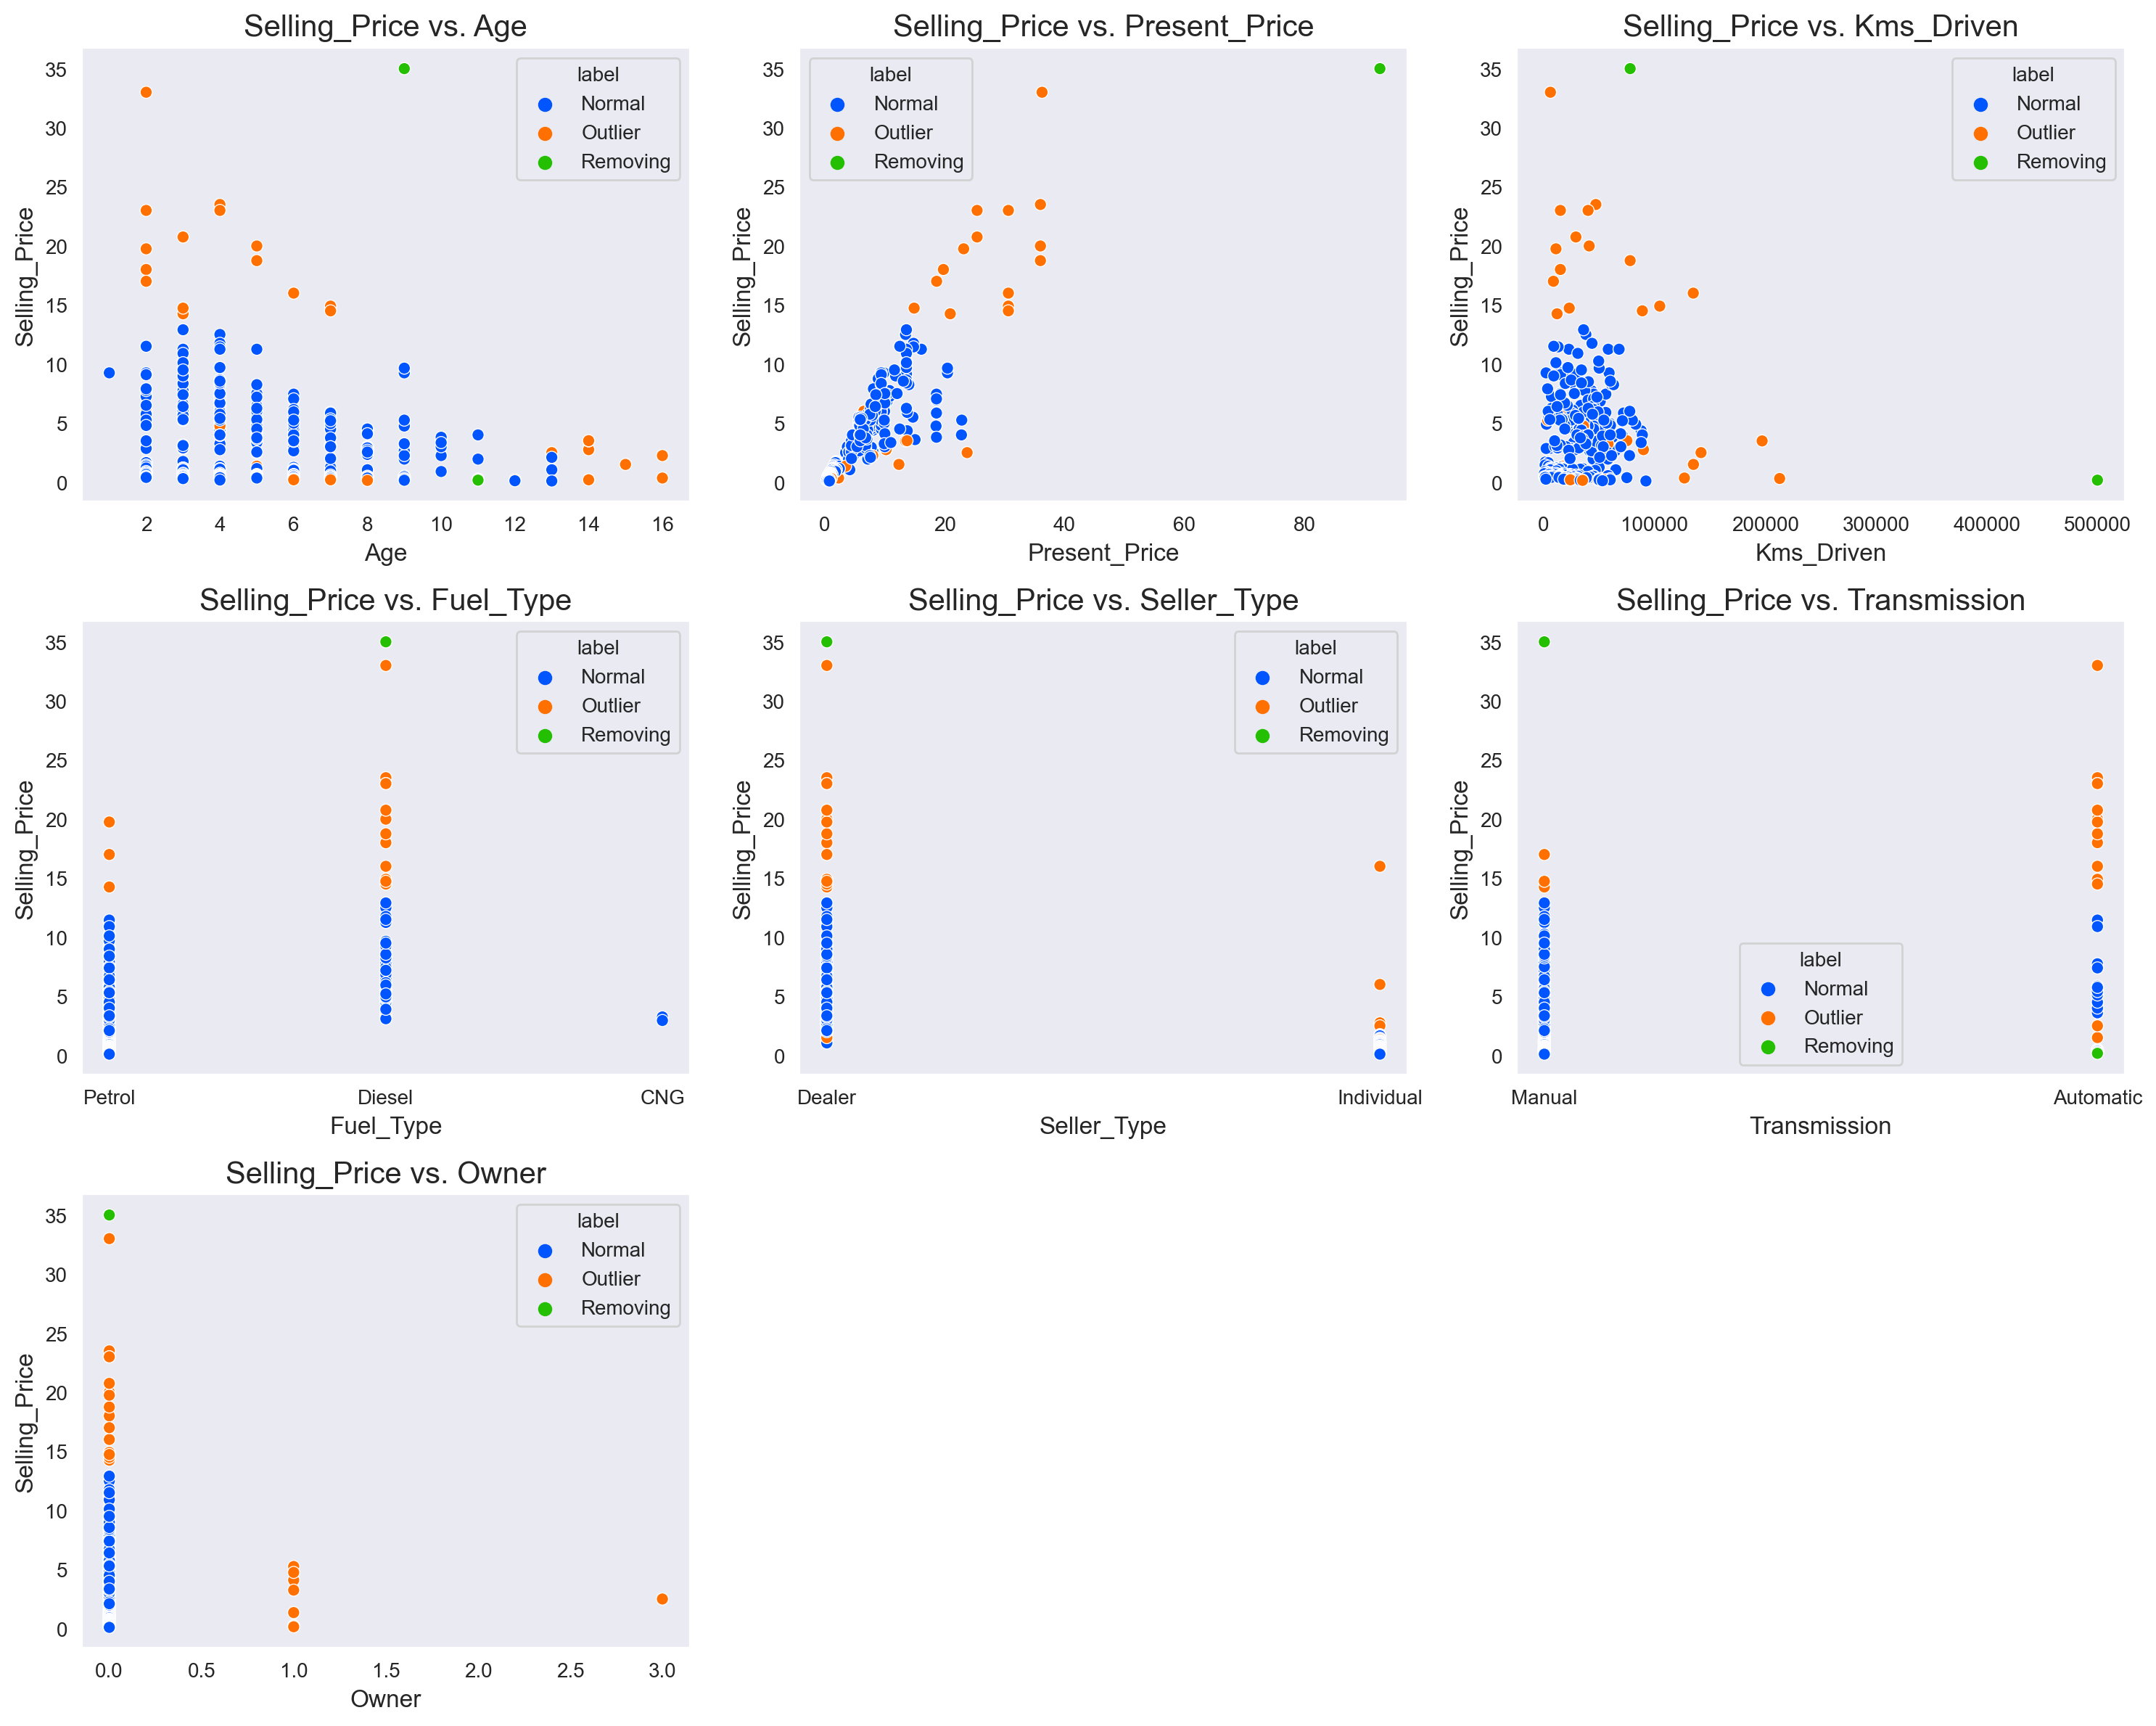

In [10]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [11]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [12]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [13]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [14]:
# Analyze the Dataset
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

Text(0.5, 0.98, 'Selling Price vs. Numerical Features')

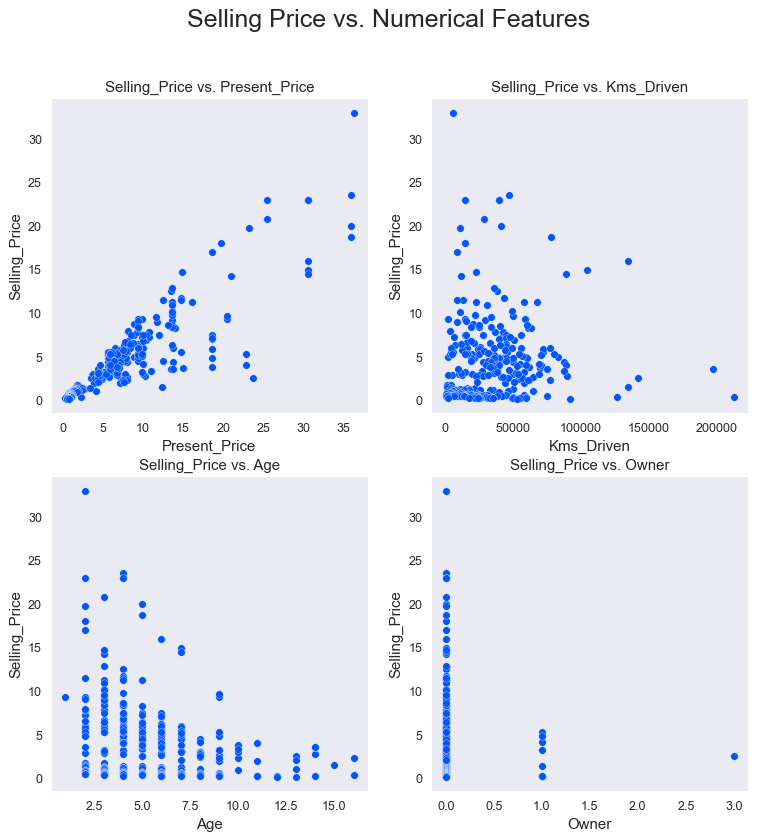

In [15]:
# Selling Price vs Numerical Features Bivariate Analysis
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(10,10), dpi=90)
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color=c, edgecolors='w', linewidths=0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size = 12)
    ax[row,col].set_xlabel(num_features[i], size = 12)
    ax[row,col].set_ylabel(target, size = 12)
    ax[row,col].grid()

plt.suptitle('Selling Price vs. Numerical Features', size = 20)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

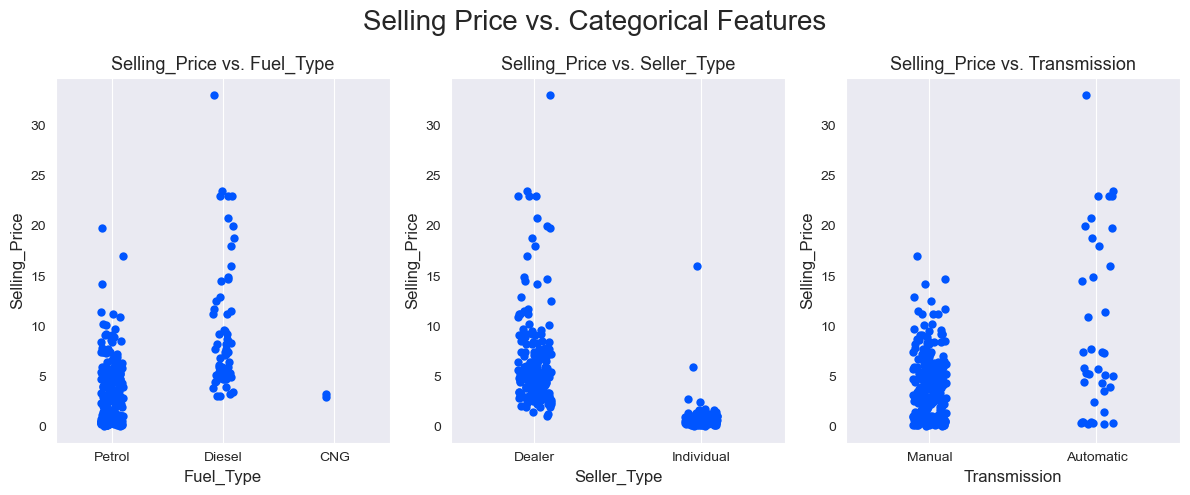

In [16]:
# Selling Price vs Categorical Features Bivariate Analysis
fig, axes = plt.subplots(nrows=1 ,ncols=3, figsize=(12,5), dpi=100)
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()

In [17]:
# Categorical Variables Encoding
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,False,True,False,True
1,6,4.75,9.54,43000,0,True,False,False,True
2,2,7.25,9.85,6900,0,False,True,False,True
3,8,2.85,4.15,5200,0,False,True,False,True
4,5,4.60,6.87,42450,0,True,False,False,True


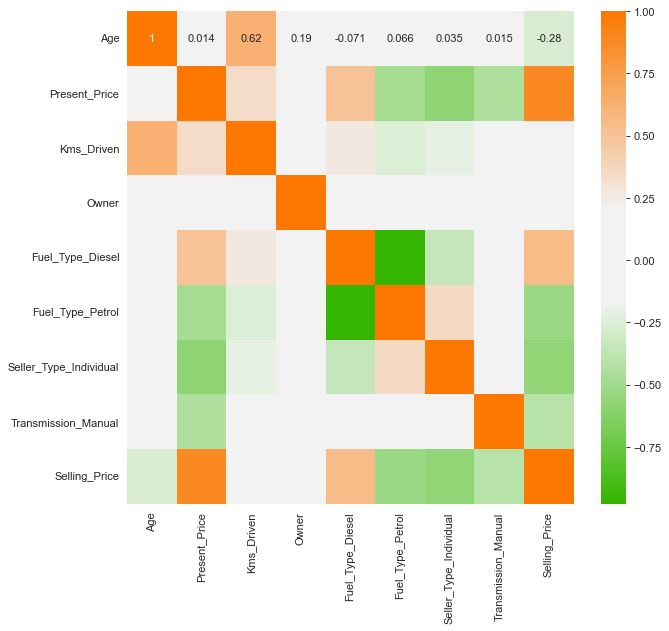

In [18]:
# Correlation Analysis
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

In [19]:
# Build the Model
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
y_test_actual = y_test

In [22]:
# Normalize the dataset
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Train the model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [24]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.302488
Present_Price Coef.,3.492729
Fuel_Type_Diesel Coef.,0.850217
Fuel_Type_Petrol Coef.,0.207319
Transmission_Manual Coef.,0.027375
Owner Coef.,-0.232722
Seller_Type_Individual Coef.,-0.377334
Kms_Driven Coef.,-0.589672
Age Coef.,-0.936339


In [25]:
# How to evaluate the model
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.198867
MSE,3.714913
RMSE,1.927411
R2-Score,0.887245


In [27]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

NameError: name 'cross_validate' is not defined

In [28]:
# Results Visualization
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

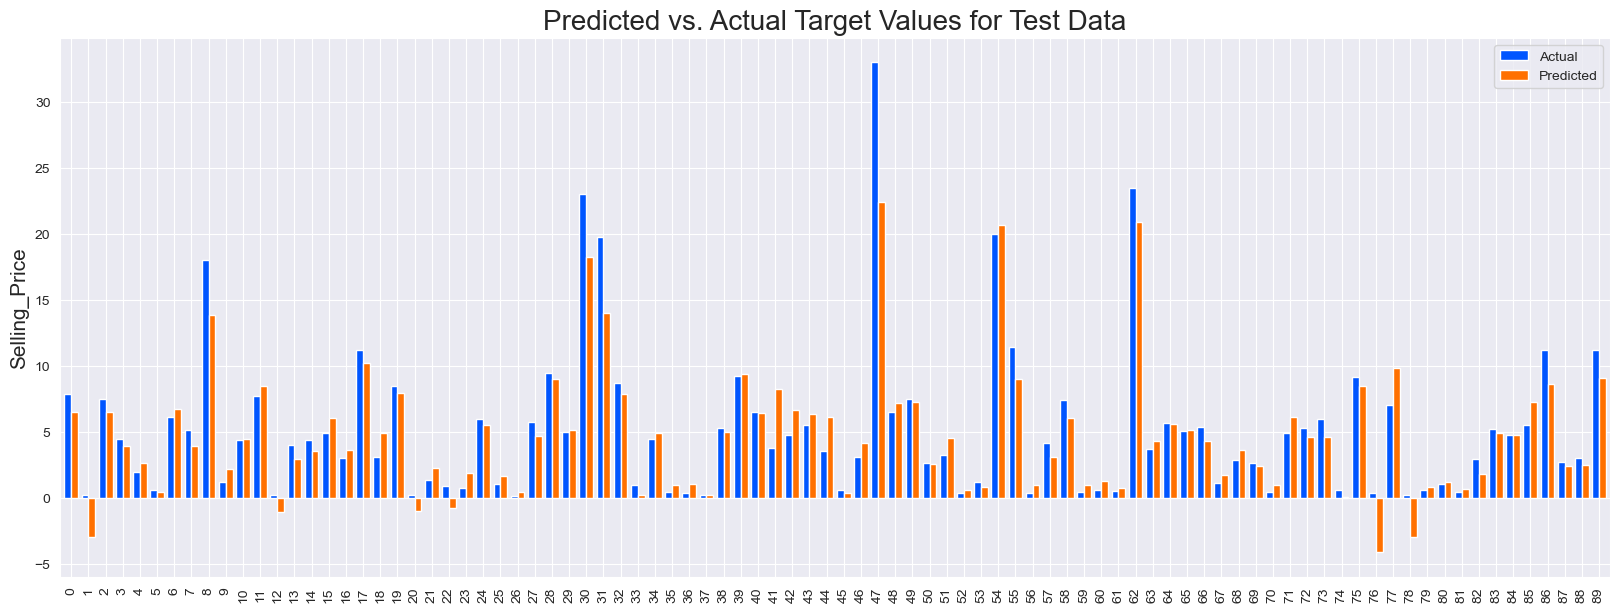

In [29]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

compare_plot(df_comp)